## Import Libraries ##

In [1]:
import numpy as np
from pydantic import Field
from enum import Enum
import matplotlib.pyplot as plt
from typing import Optional
from quantmod.models import OptionInputs

## Enums ##
Enums (short for Enumerations) are a symbolic name for a set of values. They are used in programming to represent a collection of related constants in a readable and more maintainable way.

In Python, Enum is a class that allows you to define these symbolic names for constants. The Enum class is part of the standard Python library (enum module) and it helps create sets of named values. Each member of an Enum class is a constant and has a name and a corresponding value.

We'll now define enums for the option type and exercise style.

In [2]:
# Enums for option types
class OptionType(str, Enum):
    CALL = "call"
    PUT = "put"

# Enums for exercise styles
class ExerciseStyle(str, Enum):
    AMERICAN = "american"
    EUROPEAN = "european"

## Binomial Pricing Model ##
Let's now define a binomial option pricing class.

In [3]:
# Class for Binomial Option Pricing
class BinomialOptionPricing:
    """
    Class for Binomial Option Pricing
    
    Parameters
    ----------
    inputs : OptionInputs
        Option inputs parameters
    nsteps : int
        Number of steps
    option_type : OptionType
        Option type, either 'call' or 'put'
    exercise_style : ExerciseStyle
        Exercise style, either 'american' or 'european'
    output : str, optional
        Output type ('price', 'payoff', 'value', 'delta'), by default 'payoff'
    
        
    Attributes
    ----------
    price : np.ndarray
        Matrix of option prices at each node in the binomial tree
    payoff : np.ndarray
        Matrix of option payoffs at each node
    value : np.ndarray
        Matrix of option values at each node
    delta : np.ndarray
        Matrix of option delta at each node
    binomialoption : np.ndarray
        The calculated option prices (depends on the selected output type)
    
    Methods
    -------
    plot_tree()
        Plots the binomial tree based on the selected output type
    """

    def __init__(self, 
                 inputs: OptionInputs, 
                 nsteps: int = Field(..., gt=0, description="Number of steps"), 
                 option_type: OptionType = Field(..., description="Call or Put"), 
                 exercise_style: ExerciseStyle = Field(..., description="American or European"),
                 output: Optional[str] = 'payoff'
                 ) -> None:
        
        self.inputs = inputs
        self.nsteps = nsteps
        self.option_type = option_type
        self.exercise_style = exercise_style
        self.output = output
        
        # Parameters
        self.dt = self.inputs.ttm / self.nsteps
        self.u = 1 + self.inputs.volatility * np.sqrt(self.dt)
        self.v = 1 - self.inputs.volatility * np.sqrt(self.dt)
        self.p = 0.5 + self.inputs.rate * np.sqrt(self.dt) / (2*self.inputs.volatility)
        self.df = 1 / (1 + self.inputs.rate * self.dt)
        
        # Initialize arrays
        self.price = np.zeros((self.nsteps+1, self.nsteps+1))
        self.payoff = np.zeros((self.nsteps+1, self.nsteps+1))
        self.value = np.zeros((self.nsteps+1, self.nsteps+1))
        self.delta = np.zeros((self.nsteps+1, self.nsteps+1))

        # Calculate option values
        self.binomialoption = self._binomialoption()

    def _binomialoption(self) -> np.ndarray:
        # Forward loop
        for j in range(self.nsteps+1):
            for i in range(j+1):
                self.price[i,j] = self.inputs.spot * np.power(self.v,i) * np.power(self.u,j-i)
                if self.option_type == OptionType.CALL:
                    self.payoff[i,j] = np.maximum(self.price[i,j] - self.inputs.strike, 0)
                else:
                    self.payoff[i,j] = np.maximum(self.inputs.strike - self.price[i,j], 0)

        # Reverse loop
        for j in range(self.nsteps, -1, -1):
            for i in range(j+1):
                if j == self.nsteps:
                    self.value[i,j] = self.payoff[i,j]
                    if self.option_type == OptionType.CALL:
                        self.delta[i,j] = 1 if self.price[i,j] > self.inputs.strike else 0
                    else:
                        self.delta[i,j] = -1 if self.price[i,j] < self.inputs.strike else 0
                else:
                    continuation_value = self.df * (self.p * self.value[i, j+1] + (1-self.p) * self.value[i+1, j+1])
                    self.value[i, j] = np.maximum(self.payoff[i, j] * 1 if self.exercise_style == ExerciseStyle.AMERICAN else 0, continuation_value)
                    self.delta[i,j] = (self.value[i,j+1] - self.value[i+1,j+1]) / (self.price[i,j+1] - self.price[i+1,j+1])
                
        if self.output == 'price':
            return np.around(self.price, 4)
        if self.output == 'payoff':
            return np.around(self.payoff, 4)
        elif self.output == 'value':
            return np.around(self.value, 4)
        elif self.output == 'delta':
            return np.around(self.delta, 4)
        else:
            raise ValueError("Invalid output type. Must be one of: 'price', 'payoff', 'value', 'delta'")
        
    def plot_tree(self):
        """Plot the binomial tree with option values"""
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_title(f"Binomial Tree \n\n {self.option_type}  - {self.exercise_style} - {self.output}")
        
        output_values = getattr(self, self.output)
        
        for j in range(self.nsteps + 1):
            for i in range(j + 1):
                x = j
                y = (j - 2*i)/2
                
                node_text = f"Spot: {self.price[i,j]:.2f}\n{self.output}: {output_values[i,j]:.4f}"
                ax.text(x, y, node_text, ha='center', va='center',
                        bbox=dict(facecolor='white', alpha=0.8))
                
                if j < self.nsteps:
                    ax.plot([x, x+1], [y, y+0.5], 'k-', lw=0.5)  # Up movement
                    ax.plot([x, x+1], [y, y-0.5], 'k-', lw=0.5)  # Down movement
        
        ax.set_xlim(-0.5, self.nsteps + 0.5)
        ax.set_ylim(-self.nsteps/2 - 0.5, self.nsteps/2 + 0.5)
        ax.axis('off')
        plt.show()
        

## Example ##
Let's now price the option using BinomialOptionPricing and print the tree.


Option value tree:
[[ 6.1528  2.448   0.3716  0.      0.    ]
 [ 0.     11.0919  5.1876  0.8599  0.    ]
 [ 0.      0.     19.     10.9     1.99  ]
 [ 0.      0.      0.     27.1    19.81  ]
 [ 0.      0.      0.      0.     34.39  ]]


Plot the tree:


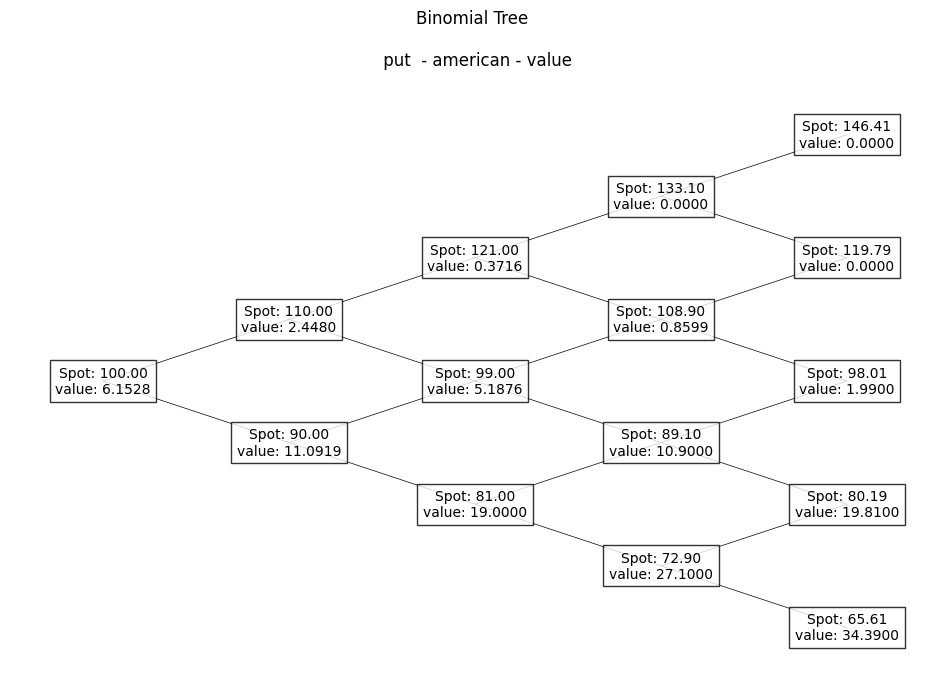

In [4]:
# Example 
if __name__ == "__main__":

    # Define input parameters
    inputs = OptionInputs(
    spot=100,
    strike=100,
    ttm=1,
    rate=0.05,
    volatility=0.2
    )

    # Instantiate the BinomialOptionPricing class
    pricer = BinomialOptionPricing(
        inputs=inputs,
        nsteps=4,
        option_type=OptionType.PUT,
        exercise_style=ExerciseStyle.AMERICAN,
        output='value'
    ) 

    # Print the tree values 
    print(f"\nOption {pricer.output} tree:")
    print(pricer.binomialoption)
    
    # Plot the tree
    print(f"\n\nPlot the tree:")
    pricer.plot_tree()

In [5]:
# Binomial Option Price
print(f"American Put Option Price using Binomial Tree Method: {pricer.value[0,0]:.2f}")

American Put Option Price using Binomial Tree Method: 6.15
